# Effects of Aggressive and Conservative Strategies for Mechanical Ventilation Liberation
This project aims to use causal inference to estimate the effects of weaning patients off mechanical ventilation sooner or later than normal, following the approach described in [Kennedy, 2018](https://arxiv.org/pdf/1704.00211.pdf). In this study we consider patients who have been on mechanical ventilation for 24 hours (our start criteria).

In [2]:
import pickle
from pprint import pprint

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ALL_WEANING_PREDICTORS is a list of all covariates intially identified as potentially useful in predicting probability of weaning
# group_by_stay is a helper function that groups a dataframe by the column 'stay_id'
from common import (
    ALL_WEANING_PREDICTORS,
    group_by_stay,
    calibration_curve
)

np.random.seed(0)

First, we exclude variables from consideration if they are missing more than 10% of the time in post-baseline times. Post-baseline in this case means we filter out records from patients at time points before our start criteria.

```
>>> full_df = pd.read_csv('mimic_iv_cxr_reports_labeled_notext.csv')
>>> post_baseline_df = full_df.loc[full_df['hour_baseline'] >= 1]
>>> post_baseline_df.to_csv('post_baseline_weaning.csv')
```

In [3]:
# Load in the required datasets
# df contains records for the duration of each stay across all stay_ids
df = pd.read_csv('post_baseline_weaning.csv')
# Cohort contains information about each patient, including
# intime, outtime, deathtime, subject_id, etc
cohort = pd.read_csv('icustays_1.0.csv')
careunits = pd.read_csv('careunits_1.0.csv')
admissions = pd.read_csv('admissions.csv')
cohort = cohort.merge(careunits).merge(admissions)

/Users/aman/VSCode Files/liberation-timing-paper/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Clean the main dataframe
Overview:
 - Remove patients who have deathtimes before the baseline criteria for the study.
 - Include only the first ICU stays for each patient
 - Fill missing values for certain columns where NaN values just mean 0
 - Create a few columns to track the value of certain variables at time t-1
 - Forward fill most of the columns to remove NaN values, since in most cases NaN simply means the variable wasn't measured at that timepoint
 - Ignore columns who still have a NaN proportion > 0.1
 
First, remove patients whose deathtimes are listed as before the baseline criteria for this study.

Ventilation status being 2 or 5 indicates invasive ventilation or the presence a tracheal tube, respectively. When the status shifts away from these values, it implies the patient was extubated, so adjust control accordingly.

In [4]:
df.loc[~df['ventilation_status'].isin([2, 5]), 'control'] = 0

Our time period of interest is every timestep up until and including the start of the first liberation attempt. So, we remove all data points past weaning.

In [5]:
df['weaning'] = 1 - df['control']
df['is_past_wean'] = group_by_stay(df, 'weaning').apply(
    lambda stay: stay.cumsum().cumsum() > 1
    )
df = df[~df['is_past_wean']]                                   

Fill missing urine output and vasopressor (`rate_std`) values with 0, since missing entries for these two columns means the value is 0 in this dataset. We do this to make sure we don't accidentally exclude the columns from the dataset because their NaN proportion appears too high, when they should really be included.

In [6]:
cols_to_impute = ['urine_output', 'last_urine_output', 'rate_std', 'last_rate_std']
df.loc[:, cols_to_impute] = df[cols_to_impute].fillna(0)

Next, we'll create some relevant columns (mostly ones that track the 'last' version of a given variable, i.e. the value at the previous timepoint).

In [7]:
df['any_vaso'] = df['rate_std'] > 0

for col in ('opioid', 'benzo', 'propofol','dex', 'driving_pressure', 'any_vaso'):
    df[f'last_{col}'] = group_by_stay(df, col).shift(periods=1)

Remove any stays corresponding to patients whose deathtimes occured before the baseline time for the study.

In [8]:
df = df.merge(cohort[['stay_id', 'deathtime', 'intime']])
# Find the actual time at which the patient's stay started,
# rather than hour `44`, for example
df['baseline_time'] = (
    pd.to_datetime(df['intime']) +
    pd.to_timedelta(df['baseline_hour'], unit='hr')
)
# Identify the stays corresponding to patients whose
# deathtimes occured before the baseline time for the study.
stays_to_omit = df.loc[ 
    df['baseline_time'] > pd.to_datetime(df['deathtime']),
    'stay_id'
].unique()

df = df.loc[~df['stay_id'].isin(stays_to_omit)]

Next, we'll filter the dataframe so only the first ICU stay for each patient is included.

In [9]:
# Select subject_id and intime from each valid stay_id in cohort
subjects = cohort.loc[
    cohort['stay_id'].isin(df['stay_id']), ['subject_id', 'stay_id', 'intime']
]
# Sort by subject_id, then by intime to identify which is the first stay
subjects.sort_values(['subject_id', 'intime'], ignore_index=True, inplace=True)
# Get those first stay_ids
first_stay_ids = subjects.groupby('subject_id')['stay_id'].first()
# Filter df (and subjects) to only include those stays
df = df[df['stay_id'].isin(first_stay_ids)]
subjects = subjects[subjects['stay_id'].isin(first_stay_ids)]

# Sort the df
df.sort_values(['stay_id', 'hour'], ignore_index=True, inplace=True)

Identify variables whose NA proportion is above 0.10, so we can exclude them.

In [10]:
cols_to_exclude = []
for c in ALL_WEANING_PREDICTORS:
    na_proportion = df[c].isna().mean()
    if na_proportion >= 0.1:
        cols_to_exclude.append(c)
        print(f'{c}: {na_proportion}')

marital_status: 0.15031893611692573


Now that we've identified which columns should be excluded from our analysis, we can create a new list of predictors.

In [11]:
weaning_predictors = [
    c for c in ALL_WEANING_PREDICTORS if c not in cols_to_exclude
]

Impute missing values (for numeric columns) with the median value.

In [12]:
for c in weaning_predictors:
    try:
        df[c].fillna(df[c].median(), inplace=True)
    # If a column is a string or object type, the median method will throw a TypeError
    except TypeError:
        pass

Now, we'll standardize our predictors.

In [13]:
# Get the numeric columns
numeric = df[weaning_predictors].select_dtypes(exclude='object').columns
# Standardize only the columns tracking the 'last' values of a variable
to_standardize = [c for c in numeric if 'last' in c]
df.loc[:, to_standardize] = StandardScaler().fit_transform(df[to_standardize])
# Sanity check to make sure the DataFrame was actually standardized
df[to_standardize].agg(['mean', 'std']).T

,mean,std
last_peep_set,1.894669e-16,1.000002
last_tidal_volume_set,-2.701398e-16,1.000002
last_resp_rate,-3.831521e-17,1.000002
last_peak_insp_pressure,-1.344547e-16,1.000002
last_plateau_pressure,-1.963215e-16,1.000002
last_mean_airway_pressure,2.193458e-16,1.000002
last_minutes_vol,2.293640e-17,1.000002
last_pao2fio2ratio,3.485278e-16,1.000002
last_driving_pressure,-1.428911e-16,1.000002
last_po2,-5.769250e-17,1.000002


For our final processing step, we'll remove extreme values from the covariates.

In [14]:
for c in weaning_predictors:
    if 'last' in c:
        df[c] = np.maximum(-5, np.minimum(df[c], 5))


### Define patient subgroups by risk
We'll later be performing a subgroup analysis, so we divide up our patients based on risk indicators like P/F ratio and SOFA score.

In [15]:
def get_pats(cond: pd.Series) -> pd.Series:
    """Return the stay_ids for patients meeting the given condition."""
    rows = (df['hour_baseline'] == 1) & cond
    return df.loc[rows, 'stay_id'].dropna().unique()

low_pfratio_pats = get_pats(df['pao2fio2ratio'] <= 150)
high_pfratio_pats = get_pats(df['pao2fio2ratio'] >= 300)

low_sofa_pats = get_pats(df['sofa_24hours'] <= 5)
high_sofa_pats = get_pats(df['sofa_24hours'] >= 12)

Next, load in pulmonary edema data and process it. [TODO: explain why] 

In [16]:
pulmonary_edema = pd.read_csv('mimic_iv_cxr_reports_labeled_notext.csv')
pulmonary_edema.head()

,subject_id,hadm_id,note_id,charttime,note_type,field_value,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,16977294,29291018.0,16977294-RR-17,2122-06-17 21:49:00,RR,C12,NaN,1.0,NaN,NaN,1.0,-1.0,1.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN
1,12233384,22824404.0,12233384-RR-78,2170-10-08 12:25:00,RR,C11,NaN,NaN,1.0,NaN,-1.0,1.0,NaN,NaN,1.0,0.0,0.0,NaN,NaN,1.0
2,11571683,22882793.0,11571683-RR-52,2138-07-05 15:02:00,RR,C11,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,17540015,21531298.0,17540015-RR-77,2189-10-14 04:45:00,RR,C12,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0
4,10150056,NaN,10150056-RR-40,2151-09-08 11:39:00,RR,C11,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN,NaN,NaN


In [17]:
# keep only rows when pulmonary edema is 1 or -1,
# and cardiomegaly is not 1
correct_vals = (pulmonary_edema['Edema'].isin((1, -1))) & (pulmonary_edema['Cardiomegaly'] != 1)
# also make sure neither edema nor cardiomegaly columns are na
not_na = pulmonary_edema[['Cardiomegaly', 'Edema']].notna().all(axis=1)
# filter by the above conditions
pulmonary_edema = pulmonary_edema.loc[correct_vals & not_na]
# and merge in the following columns from cohort
pulmonary_edema = pulmonary_edema.merge(
    cohort[['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime']])

In [18]:
# convert various time columns to pandas datetime objects
for col in ('charttime', 'intime', 'outtime'):
    pulmonary_edema[col] = pd.to_datetime(pulmonary_edema[col])

# create new columns tracking duration between charttime and intime, and outtime and intime
pulmonary_edema['charthour'] = pulmonary_edema['charttime'] - pulmonary_edema['intime']
pulmonary_edema['outhour'] = pulmonary_edema['outtime'] - pulmonary_edema['intime']

# only include records where charthour < outhour
pulmonary_edema = pulmonary_edema.loc[pulmonary_edema['charthour'] < pulmonary_edema['outhour']]

In [19]:
# create new table tracking only essential values
# from pulmonary_edema
edema_df = pulmonary_edema.loc[:, ['stay_id', 'charthour', 'Edema']]
# group by stay_id and edema, and take the minimum value for each group
edema_df = edema_df.groupby(['stay_id', 'Edema']).min().reset_index()

In [20]:
# convert charthour to an array of ints
# counting the total hours the timedelta represents
edema_df['charthour'] = (edema_df['charthour']
    .dt.ceil(freq='H')
    .dt.total_seconds()
    / 3600
).astype(int)
# then set all negative values to 1
edema_df['hour'] = np.maximum(1, edema_df['charthour'])

In [21]:
# ok i have no idea why we do this, but
# set all values for pulmonary_edema to 1 ??
edema_df['Edema'] = 1

# then merge in the data into our main dataframe
edema_df.rename({'Edema': 'pulmonary_edema'}, axis=1, inplace=True)
df = df.merge(edema_df[['stay_id', 'hour', 'pulmonary_edema']], how='left')

# set all na values to zero
df['pulmonary_edema'].fillna(0, inplace=True)

# then set the values at each intermediate time point to be
# the cumulative number of timesteps where pulmonary_edema was true
df['pulmonary_edema'] = df.groupby('stay_id')['pulmonary_edema'].cumsum()

In [22]:
# define another subset of patients: those with ards
ards_criteria = (df['pao2fio2ratio'] <= 300) & (df['pulmonary_edema'] == 1)
ards_pats = df.loc[ards_criteria, 'stay_id'].unique()

In [23]:
# now that we have our pulmonary edema data,
# we'll add it to our covariates list
weaning_predictors.append('pulmonary_edema')

# save the processed data
df.to_csv('processed_data.csv')

### Fit weaning predictor
The final step before modeling is to define our training data. 

For context, any commented-out code in the following cells represents what was/would be run had the notebook used the full dataframe instead of a sampled dataframe.

In [24]:
MODEL_PARAMS = {
    'penalty': 'l2',
    'max_iter': 2000,
}
# Dataframe checkpoint (loading in full processed dataset)
df = pd.read_csv('processed_data.csv')

X = df.loc[:, weaning_predictors]
y = df['weaning']

# Encode string/object columns as integers
for col in X.select_dtypes(include='object'):
    X[col] = LabelEncoder().fit_transform(X[col])

In [25]:
weaning_predictor = LogisticRegression(**MODEL_PARAMS).fit(X, y)

with open('models/weaning_predictor.pkl', 'wb') as f:
    pickle.dump(weaning_predictor, f)

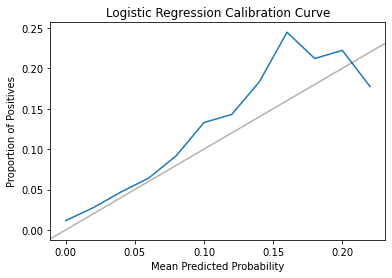

In [26]:
# Model checkpoint
with open('models/weaning_predictor.pkl', 'rb') as f:
    weaning_predictor = pickle.load(f)

# create a calibration curve
df['p_hat'] = weaning_predictor.predict_proba(X)[:, 1]

calibration_curve(
    df, 'p_hat', 'weaning', 'Logistic Regression Calibration Curve', 
    filename='logistic_reg_calibration.png'
    )

Train a calibrated regressor since the above graph shows that the current predictor is poorly calibrated.

In [27]:
calibrated_predictor = CalibratedClassifierCV(
    base_estimator=LogisticRegression(**MODEL_PARAMS),
    method='isotonic'
    ).fit(X, y)

with open('models/calibrated_predictor.pkl', 'wb') as f:
    pickle.dump(calibrated_predictor, f)

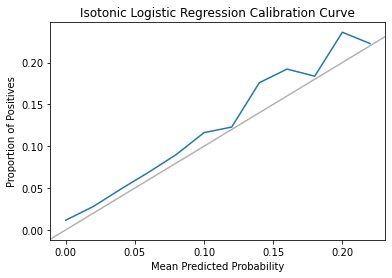

In [28]:
# Model checkpoint
with open('models/calibrated_predictor.pkl', 'rb') as f:
    calibrated_predictor = pickle.load(f)

df['propensity_score'] = calibrated_predictor.predict_proba(X)[:, 1]

calibration_curve(
    df, 'propensity_score', 'weaning', 'Isotonic Logistic Regression Calibration Curve',
    filename='isoreg_calibration.png'
    )

Since we'll be performing subgroup analyses later, we'll fit individual weaning predictors on each subset we defined above.

In [29]:
# def train_model(df_subset) -> CalibratedClassifierCV:
#     X_subset = df_subset.loc[:, weaning_predictors]
#     y_subset = df_subset['weaning']
#     for col in X_subset.select_dtypes(include='object'):
#         X_subset[col] = LabelEncoder().fit_transform(X_subset[col])
    
#     return CalibratedClassifierCV(
#         base_estimator=LogisticRegression(**MODEL_PARAMS),
#         method='isotonic'
#     ).fit(X_subset, y_subset)

# model_pf = train_model(data_pf)
# model_pf_high = train_model(data_pf_high)
# model_sofa = train_model(data_sofa)
# model_sofa_low = train_model(data_sofa_low)
# model_ards = train_model(data_ards)

### Effect estimation
With our well-calibrated model for the probability of weaning, we can now estimate the causal effect of incrementing this propensity score. To do so, there are four major steps:

1. Construct time-dependent weights W_t for each subject and timepoint
2. Calculate the cumulative weight for each subject across all timepoints
3. Multiply each cumulative weight by the outcome
4. Take the average of these products to estimate the mean counterfactual outcome

Since we have multiple outcomes of interest, we first calculate the cumulative weights and later multiply them by each outcome.

In [30]:
# round to remove floating point errors
DELTAS = np.around(np.arange(0.5, 2.1, 0.1), decimals=1)

def cumulative_weights(data, truncated=True, propensity_col: str = 'propensity_score'):
    """
    For each value of delta, calculate weights for each patient using the given
    propensity scores.
    """
    weights = {}
    for delta in DELTAS:
        A = data['weaning']
        pi_hat = data[propensity_col]
        weight_col = f'weights_d{delta}'
        # construct time-dependent weights for each subject at each timepoint
        data.loc[:, weight_col] = (
            ((delta * A) + 1 - A) /
            ((delta * pi_hat) + 1 - pi_hat)
        )
        # calculate cumulative product of weights
        cumulative_products = group_by_stay(data, weight_col).prod()
        # truncate cumulative weights at the 99th percentile
        if truncated:
            max_val = cumulative_products.quantile(q=0.99)
            cumulative_products = np.minimum(cumulative_products, max_val)
        # save the weights
        weights[delta] = cumulative_products
    return weights

In [31]:
# calculate the overall weights
weights = cumulative_weights(df)

# now breakdown by subgroup
def weights_by_subgroup(stay_ids):
    return {delta: col[stay_ids] for delta, col in weights.items()}

weights_pf = weights_by_subgroup(low_pfratio_pats)
weights_pf_high = weights_by_subgroup(high_pfratio_pats)
weights_sofa = weights_by_subgroup(high_sofa_pats)
weights_sofa_low = weights_by_subgroup(low_sofa_pats)
weights_ards = weights_by_subgroup(ards_pats)

First, examine the impact on time until weaning. The goal of this analysis is to make sure that our incremental interventions actually affect the counterfactual time until weaning for a given patient.

In [32]:
# time until weaning outcome
grouped = group_by_stay(df, 'weaning')
df['time_until_wean'] = (grouped
    # Apply the .max() and .size() functions to the weaning groups
    # This determines 1. whether weaning occured
    # and 2. the number of hours at which weaning began (if it did)
    .agg(['max', 'size'])
    # If weaning did occur, return the number of hours after baseline with it occured
    # Otherwise, we set the value to 720 hours
    .apply(lambda row: row['size'] if row['max'] else 720, axis=1)
    # Repeat rows to ensure the size of the array matches what's in the dataframe
    .repeat(grouped.size())
    # Reset index so column can be inserted into the dataframe properly
    .reset_index(drop=True)
)

Define a helper function to calculate our estimates given a set of cumulative weights and a given outcome.

In [33]:
def calculate_estimates(weights, outcome):
    """
    Estimate the effect on the given outcome of intervening on weawning.
    """
    if isinstance(outcome, pd.core.groupby.generic.SeriesGroupBy):
        outcome = outcome.first()
    results = {}
    for delta in DELTAS:
        # multiply by outcome
        weighted_products = weights[delta].multiply(outcome)
        # average over subjects and add to results
        results[delta] = weighted_products.mean()
    return results

In [34]:
wean_times_results = calculate_estimates(weights, group_by_stay(df, 'time_until_wean'))
pprint(wean_times_results)

{0.5: 73.17804449216197,
 0.6: 65.84771945407431,
 0.7: 59.116308042511676,
 0.8: 53.24077883791837,
 0.9: 48.25067452639452,
 1.0: 44.05771559262774,
 1.1: 40.21565674731608,
 1.2: 37.22467854882971,
 1.3: 34.76077641841339,
 1.4: 32.66538157361617,
 1.5: 30.847460733613048,
 1.6: 29.247992328081157,
 1.7: 27.82550949893563,
 1.8: 26.549351828072524,
 1.9: 25.396068061869638,
 2.0: 24.347280958565097}


Now, get the results for each subgroup.

In [35]:
# for convenience, name each subgroup
# (the groups are constant so this won't cause problems)
SUBGROUPS = (
    {  
        'SOFA >= 12': high_sofa_pats,
        'SOFA <= 5': low_sofa_pats,
    },
    {
        'PaO2/FiO2 Ratio <= 150': low_pfratio_pats,
        'PaO2/FiO2 Ratio >= 300': high_pfratio_pats,
    }
)

def get_subgroup_results(data: pd.DataFrame, outcome_col: str):
    """
    Given a dataframe with the stay_id column and a specified outcome column,
    return a dictionary of the results broken down by each subgroup.
    """
    results = {}
    groups = {**SUBGROUPS[0], **SUBGROUPS[1]}
    for name, pats in groups.items():
        subgroup_weights = weights_by_subgroup(pats)
        subgroup_data = data.loc[data['stay_id'].isin(pats)]
        outcome = group_by_stay(subgroup_data, outcome_col)
        results[name] = calculate_estimates(subgroup_weights, outcome)
    return results

wean_times_subgroup_results = get_subgroup_results(df, 'time_until_wean')

In [36]:
def display_results(title, ylabel, cohort_results, subgroup_results, filename=''):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    for grps, ax in zip(SUBGROUPS, axs):
        # plot full cohort data on each subplot
        ax.scatter(cohort_results.keys(), cohort_results.values(), color='black', label='Full cohort')
        # then plot sofa on ax[0] and pf on ax[1]
        for name in grps:
            ax.scatter(
                subgroup_results[name].keys(),
                subgroup_results[name].values(),
                label=name
                )
        # now for cosmetics
        ax.set_title(title)
        ax.set_xlabel('Delta')
        ax.set_ylabel(ylabel)
        # add a vertical line at x = 1 to each plot
        ax.axvline(1, color='grey', alpha=0.5)
        # and a legend
        ax.legend()
    
    if filename:
        plt.savefig(f'images/{filename}.png', facecolor='white')
    
    plt.show()

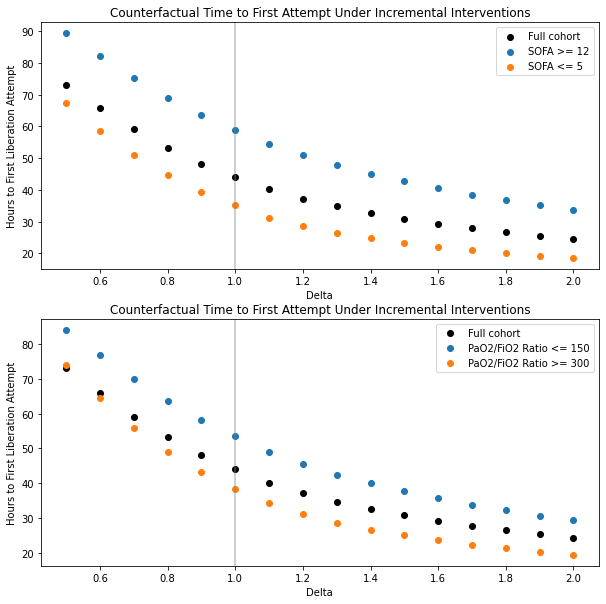

In [37]:
display_results(
    'Counterfactual Time to First Attempt Under Incremental Interventions',
    'Hours to First Liberation Attempt',
    wean_times_results,
    wean_times_subgroup_results,
    'wean_times'
)

Next, calculate the effect on mortality.

In [38]:
mortality_results = calculate_estimates(weights, group_by_stay(df, 'hospital_expire_flag'))
mortality_subgroup_results = get_subgroup_results(df, 'hospital_expire_flag')

pprint(mortality_results)

{0.5: 0.33519454698033735,
 0.6: 0.3373248962201278,
 0.7: 0.33730234644058643,
 0.8: 0.336488820414818,
 0.9: 0.33554249734297764,
 1.0: 0.33472353020314904,
 1.1: 0.3337681044675111,
 1.2: 0.33329447693110337,
 1.3: 0.3330667012836953,
 1.4: 0.33296851671825806,
 1.5: 0.332935215521177,
 1.6: 0.3329279216723524,
 1.7: 0.33292241066739797,
 1.8: 0.3329034404683114,
 1.9: 0.33286156708116055,
 2.0: 0.3327912110627911}


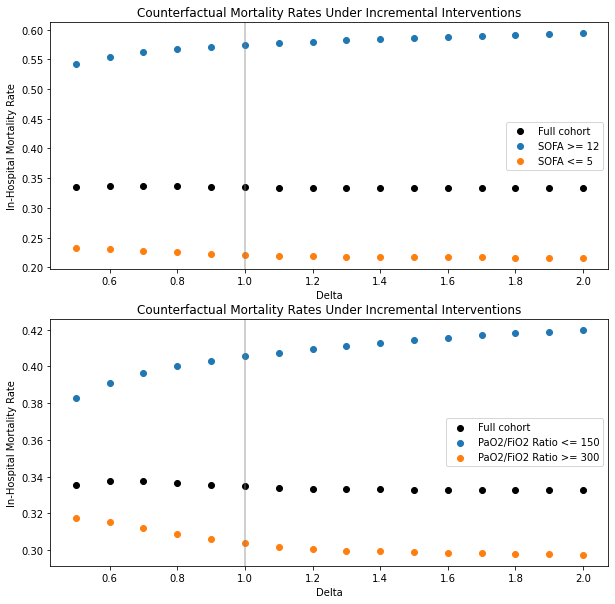

In [39]:
display_results(
    'Counterfactual Mortality Rates Under Incremental Interventions',
    'In-Hospital Mortality Rate',
    mortality_results,
    mortality_subgroup_results,
    'mortality'
)

Now construct the ICU-free days outcome.

In [140]:
# 1. find baseline time
# 2. find how many days in the 30 days post-baseline the patient was alive and not in the icu
# assumptions:
#   if the patient didn't die in a hospital stay, they didn't die
#   if they died in hospital, assume discharge time is time of death

# make sure dtypes agree
df['baseline_time'] = pd.to_datetime(df['baseline_time'])

for time_col in ('intime', 'outtime', 'deathtime'):
    cohort[time_col] = pd.to_datetime(cohort[time_col])

# Merge dataframe containing in and out time
baseline_hour_df = cohort.loc[
    :, ['stay_id', 'intime', 'outtime', 'subject_id']
    ].merge(
        df.loc[df['hour_baseline'] == 1, ['stay_id', 'baseline_hour', 'baseline_time']]
    )

icu_duration_df = cohort.merge(
    baseline_hour_df.loc[:, ['subject_id', 'baseline_time']].drop_duplicates()
    )

In [41]:
icu_duration_df['max_time'] = icu_duration_df['baseline_time'] + pd.Timedelta(30, unit="days")
# remove ones where outtime <= baseline_time
icu_duration_df = icu_duration_df.loc[icu_duration_df['outtime'] > icu_duration_df['baseline_time']]
# remove rows with max_time <= intime
icu_duration_df = icu_duration_df.loc[icu_duration_df['max_time'] > icu_duration_df['intime']]

In [42]:
# Calculate duration of each stay
icu_duration_df = icu_duration_df.sort_values('subject_id')
stay_start = np.maximum(icu_duration_df['intime'], icu_duration_df['baseline_time'])
stay_end = np.minimum(icu_duration_df['outtime'], icu_duration_df['max_time'])
icu_duration_df['icu_stay_durations'] = stay_end - stay_start

In [43]:
icu_duration_df['death_day'] = icu_duration_df['deathtime'] - icu_duration_df['baseline_time']
# fill all entries with deathtime before baseline_time with 0
icu_duration_df.loc[icu_duration_df['death_day'] < pd.to_timedelta(0), 'death_day'] = pd.to_timedelta(0)
# fill all entries with NaN deathtime with a dummy value
icu_duration_df['death_day'].fillna(pd.Timedelta(100000, unit="days"), inplace=True)

In [44]:
max_val = pd.Timedelta(30, "days")
icu_duration_df['max'] = icu_duration_df['death_day'].where(
    icu_duration_df['death_day'] <= max_val, max_val
    )
max_df = icu_duration_df[['subject_id', 'max']].drop_duplicates()
max_df = max_df.groupby('subject_id', as_index=False).min()

In [45]:
duration_df = icu_duration_df.groupby('subject_id', as_index=False)['icu_stay_durations'].sum()

In [46]:
icu_outcome_df = max_df.merge(duration_df)
icu_outcome_df.rename(columns = {'icu_stay_durations' : 'icu_duration'}, inplace=True)

In [47]:
# construct outcome column (take ceil of the time difference to the nearest day)
icu_outcome_df['outcome'] = (icu_outcome_df['max'] - icu_outcome_df['icu_duration']).dt.ceil('d')
# and convert to an int
icu_outcome_df['outcome'] = icu_outcome_df['outcome'].dt.days
# merge with subjects to get stay id
icu_outcome_df = icu_outcome_df.merge(subjects[['subject_id', 'stay_id']])
icu_outcome_df.sort_values('stay_id', inplace=True)

Calculate estimates!

In [48]:
icu_free_days_results = calculate_estimates(weights, group_by_stay(icu_outcome_df, 'outcome'))
icu_free_days_subgroup_results = get_subgroup_results(icu_outcome_df, 'outcome')

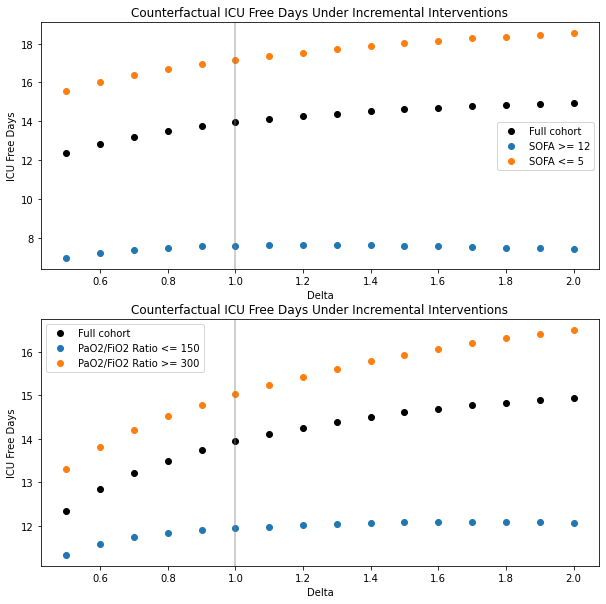

In [49]:
display_results(
    'Counterfactual ICU Free Days Under Incremental Interventions',
    'ICU Free Days',
    icu_free_days_results,
    icu_free_days_subgroup_results,
    filename='icufreedays'
)

Next, we'll analyze the impact on ventilator-free days.

In [141]:
vent = pd.read_csv('ventilator.csv')

In [142]:
vent_duration_df = vent.merge(baseline_hour_df[['stay_id', 'subject_id', 'baseline_time']])
vent_duration_df = vent_duration_df.loc[vent_duration_df['ventilation_status'].isin(("InvasiveVent", "Trach"))]
vent_duration_df['max_time'] = vent_duration_df['baseline_time'] + pd.Timedelta(30, "days")

In [143]:
# convert endtime + max_time + starttime to datetime columns
for time_col in ('starttime', 'endtime'):
    vent_duration_df[time_col] = pd.to_datetime(vent_duration_df[time_col])

In [144]:
# remove rows with endtime <= baseline_time
vent_duration_df = vent_duration_df[vent_duration_df['endtime'] > vent_duration_df['baseline_time']]
vent_duration_df = vent_duration_df[vent_duration_df['max_time'] > vent_duration_df['starttime']]

# the ceil function rounds up to the nearest day, then use the dt.days accessor to convert to an integer
vent_duration_df['startday'] = (vent_duration_df['starttime'] - vent_duration_df['baseline_time']).dt.ceil('D').dt.days
vent_duration_df['endday'] = (vent_duration_df['endtime'] - vent_duration_df['baseline_time']).dt.ceil('D').dt.days

# min startday at 1
vent_duration_df.loc[vent_duration_df['startday'] < 1, 'startday'] = 1
# cap endday at 30
vent_duration_df.loc[vent_duration_df['endday'] > 30, 'endday'] = 30

# add 1 to endday inside the arange function to include the endpoint
vent_duration_df['vent_days'] = vent_duration_df.apply(lambda r: np.arange(r['startday'], r['endday'] + 1), axis=1)

death_cohort = cohort[~cohort['deathtime'].isna()]

baseline_hour_df = baseline_hour_df.merge(death_cohort[['subject_id', 'deathtime']].drop_duplicates(), how='left')
baseline_hour_df['deathtime'] = pd.to_datetime(baseline_hour_df['deathtime'])
# LOOK INTO DEATH_DAY WTF
baseline_hour_df['death_day'] = (baseline_hour_df['deathtime'] - baseline_hour_df['baseline_time']).dt.ceil('D').dt.days
# min death_day at 1
baseline_hour_df.loc[baseline_hour_df['death_day'] < 1, 'death_day'] = 1
baseline_hour_df['death_day'].fillna(10000000, inplace=True)

In [122]:
baseline_hour_df.loc[~baseline_hour_df['stay_id'].isin(vent_duration_df['stay_id'].unique())]

,stay_id,intime,outtime,subject_id,baseline_hour,baseline_time,deathtime,death_day,vent_days,death_days
4,32190274,2166-02-27 00:03:44,2166-03-04 06:36:21,11190732,31,2166-02-28 07:03:44,2166-03-04 12:30:00,5.0,NaN,"[5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13..."
341,36693551,2165-10-27 12:06:00,2165-11-11 14:51:37,11517178,259,2165-11-07 07:06:00,NaT,10000000.0,NaN,[]
386,30023204,2124-07-09 16:43:55,2124-07-13 15:26:02,18738693,72,2124-07-12 16:43:55,NaT,10000000.0,NaN,[]
406,31524880,2166-03-26 11:18:04,2166-03-28 13:14:35,13911932,25,2166-03-27 12:18:04,NaT,10000000.0,NaN,[]
587,33318703,2123-05-11 11:05:49,2123-05-13 15:16:58,16685152,49,2123-05-13 12:05:49,NaT,10000000.0,NaN,[]
...,...,...,...,...,...,...,...,...,...,...
7298,37671180,2147-01-13 15:26:21,2147-01-15 02:11:40,11441218,29,2147-01-14 20:26:21,2147-01-15 22:25:00,2.0,NaN,"[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,..."
7363,33636897,2140-05-21 19:48:55,2140-05-24 17:10:44,11802843,25,2140-05-22 20:48:55,NaT,10000000.0,NaN,[]
7371,34330521,2142-10-22 03:31:11,2142-10-31 16:02:45,10388043,32,2142-10-23 11:31:11,2142-10-31 15:15:00,9.0,NaN,"[9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0..."
7396,36321418,2166-07-28 15:17:00,2166-08-02 11:29:14,17049635,57,2166-07-31 00:17:00,2167-03-03 06:45:00,216.0,NaN,[]


In [145]:
patients = vent_duration_df['stay_id'].unique()

# create a blank dataframe indexed by stay_id
vent_days_df = pd.DataFrame(index=patients)
vent_days_df.index.rename('stay_id', inplace=True)
# create the outcome
vent_days_df['vent_days'] = group_by_stay(vent_duration_df, 'vent_days').apply(lambda g: np.concatenate([entry for entry in g]))
# reset the stay_id index to a column so it can be merged upon
vent_days_df.reset_index(inplace=True)
# merge it in
baseline_hour_df = baseline_hour_df.merge(vent_days_df, on='stay_id', how='left')
# replace NaN entries with an empty list
baseline_hour_df['vent_days'] = baseline_hour_df['vent_days'].fillna('').apply(list) # first fill with '' bc lists cant be passed to fillna

baseline_hour_df['death_days'] = baseline_hour_df.apply(lambda r: np.arange(r['death_day'], 31), axis=1)

def get_vent_free_days(row):
    """Get the ventilator free days outcome for the given row."""
    days = np.concatenate((row['vent_days'], row['death_days']))
    # remove duplicates
    days = list(set(days))
    # get the outcome
    return 30 - len(days)

baseline_hour_df['vent_free_days'] = baseline_hour_df.apply(get_vent_free_days, axis=1)

baseline_hour_df.sort_values('stay_id', inplace=True)

In [134]:
vent_duration_df.loc[vent_duration_df['stay_id'] == 30006983]

,stay_id,starttime,endtime,ventilation_status,subject_id,baseline_time,max_time,startday,endday,vent_days
26130,30006983,2159-11-10 05:00:00,2159-11-11 12:00:00,InvasiveVent,18756985,2159-10-13 18:56:42,2159-11-12 18:56:42,28,29,"[28, 29]"
26131,30006983,2159-10-12 18:00:00,2159-10-14 19:00:00,InvasiveVent,18756985,2159-10-13 18:56:42,2159-11-12 18:56:42,1,2,"[1, 2]"
26132,30006983,2159-10-31 15:00:00,2159-10-31 20:00:00,InvasiveVent,18756985,2159-10-13 18:56:42,2159-11-12 18:56:42,18,19,"[18, 19]"
26133,30006983,2159-10-17 17:00:00,2159-10-31 00:00:00,InvasiveVent,18756985,2159-10-13 18:56:42,2159-11-12 18:56:42,4,18,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."


In [133]:
baseline_hour_df.sort_values('stay_id')

,stay_id,intime,outtime,subject_id,baseline_hour,baseline_time,deathtime,death_day,vent_days,death_days,vent_free_days
5061,30003598,2189-04-14 20:27:25,2189-04-19 15:57:41,15332791,44,2189-04-16 16:27:25,NaT,10000000.0,[1],[],29
3325,30003749,2120-11-05 16:03:00,2120-11-07 08:19:44,12227720,27,2120-11-06 19:03:00,2120-11-07 03:41:00,1.0,[1],"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0
3092,30004391,2153-09-05 13:12:00,2153-09-13 18:21:18,18730522,25,2153-09-06 14:12:00,NaT,10000000.0,"[1, 2]",[],28
4848,30006983,2159-10-12 03:56:42,2159-11-22 09:29:33,18756985,39,2159-10-13 18:56:42,2159-11-22 07:26:00,40.0,"[28, 29]",[],28
1340,30007565,2141-07-09 01:34:00,2141-07-27 20:53:36,16828280,25,2141-07-10 02:34:00,NaT,10000000.0,"[8, 9]",[],28
...,...,...,...,...,...,...,...,...,...,...,...
2682,39995213,2127-12-11 18:03:43,2127-12-17 21:07:04,13534199,26,2127-12-12 20:03:43,NaT,10000000.0,[1],[],29
6019,39995735,2124-08-15 10:59:52,2124-08-22 17:01:54,11539827,32,2124-08-16 18:59:52,NaT,10000000.0,"[1, 2, 3, 4]",[],26
2298,39996867,2165-06-07 14:19:00,2165-06-24 21:45:15,12478391,26,2165-06-08 16:19:00,NaT,10000000.0,"[12, 13, 14, 15]",[],26
674,39998012,2133-02-03 06:48:42,2133-02-09 02:55:42,17874908,33,2133-02-04 15:48:42,2133-02-08 23:02:00,5.0,"[1, 2, 3]","[5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13...",1


Get estimates!

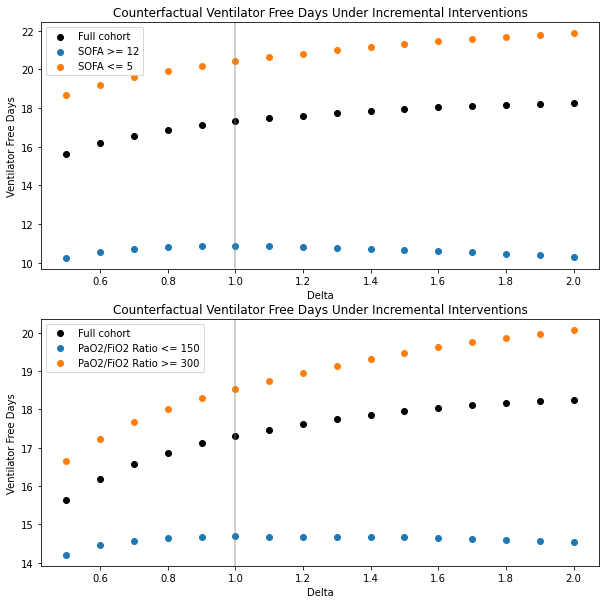

In [152]:
vent_free_days_results = calculate_estimates(weights, group_by_stay(baseline_hour_df, 'vent_free_days'))
vent_free_days_subgroup_results = get_subgroup_results(baseline_hour_df, 'vent_free_days')

display_results(
    'Counterfactual Ventilator Free Days Under Incremental Interventions',
    'Ventilator Free Days',
    vent_free_days_results,
    vent_free_days_subgroup_results,
    filename='ventfreedays'
)

Bootstrap on outcomes to determine variability.

In [ ]:
N_BOOTSTRAPS = 100
stays = df['stay_id'].unique()

In [ ]:
N_BOOTSTRAPS = 100
outcome_estimates = {d: [] for d in DELTAS}

stays = df['stay_id'].unique()

def get_bootstrap_sample():
    """Randomly sample from the dataframe, keeping the number of stays the same."""
    sampled_stays = np.random.choice(stays, size=stays.shape, replace=True)
    # Determine how many times each stay should be repeated (since we sample w/replacement)
    num_repeats = {s: 0 for s in sampled_stays}
    for s in sampled_stays:
        num_repeats[s] += 1
    # Choose only the selected stays
    curr_data = df.loc[df['stay_id'].isin(sampled_stays)]
    indices = []
    for stay, idxs in group_by_stay(curr_data).groups.items():
        indices += (num_repeats[stay] * list(idxs))
    return curr_data.reindex(indices)

for i in range(N_BOOTSTRAPS):
    r = calculate_estimates(
        DELTAS,
        data=get_bootstrap_sample(),
    )
    for delta, estimate in r.items():
        outcome_estimates[delta].append(estimate)

outcome_estimates = pd.DataFrame(outcome_estimates)
# outcome_estimates.to_csv('outcome_estimates.csv')
outcome_estimates.head()

In [ ]:
to_plot = outcome_estimates.iloc[:, 2:17]

In [ ]:
bounds = outcome_estimates.quantile(0.025), outcome_estimates.quantile(0.975)
# bounds = outcome_estimates.min(), outcome_estimates.max()
plt.fill_between(delta_vals, bounds[0], bounds[1], alpha=0.5)
plt.plot(mortality_results.keys(), mortality_results.values())
plt.show()

Now that we have an understanding of the variability of our estimates, we'll run one final analysis. This time, instead of looking at the impact of weaning interventions on mortality, our outcome of interest will be the amount of time until first weaning attempt. The goal of this is to see how much of an impact the interventions actually have on the time before first attempt.

In [ ]:
grouped = group_by_stay(df, 'weaning')
df['time_until_wean'] = (grouped
    # Apply the .max() and .size() functions to the weaning groups
    # This determines 1. whether weaning occured
    # and 2. the number of hours at which weaning began (if it did)
    .agg(['max', 'size'])
    # If weaning did occur, return the number of hours after baseline with it occured
    # Otherwise, we set the value to 720 hours
    .apply(lambda row: row['size'] if row['max'] else 720, axis=1)
    # Repeat rows to ensure the size of the array matches what's in the dataframe
    .repeat(grouped.size())
    # Reset index so column can be inserted into the dataframe properly
    .reset_index(drop=True)
)

In [ ]:
time_until_wean_results = calculate_estimates(delta_vals, outcome_col='time_until_wean')
pprint(time_until_wean_results)

In [ ]:
plt.xlabel('Delta')
plt.ylabel('Mean Estimated Hours Until Weaning Begins')
plt.plot(time_until_wean_results.keys(), time_until_wean_results.values())
plt.axvline(1, color='grey', alpha=0.5)
plt.minorticks_on()
plt.savefig('images/time_until_wean_results.png', facecolor='white')
plt.show()